<a href="https://colab.research.google.com/github/tommasomora01/StockIndexClassification/blob/main/StockIndexClassification_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import shutil
import os
directory = '/content/StockIndexClassification'

# Verifica se la directory esiste
if os.path.exists(directory):
    # Rimuovi la directory e il suo contenuto
    shutil.rmtree(directory)
    print(f'Directory "{directory}" rimossa.')
else:
    print(f'Directory "{directory}" non esiste.')
!git clone https://github.com/tommasomora01/StockIndexClassification.git
%run /content/StockIndexClassification/StockIndexClassification_COLABnew.ipynb

Directory "/content/StockIndexClassification" rimossa.
Cloning into 'StockIndexClassification'...
remote: Enumerating objects: 699, done.
remote: Counting objects: 100% (699/699), done.
remote: Compressing objects: 100% (527/527), done.
remote: Total 699 (delta 226), reused 596 (delta 166), pack-reused 0 (from 0)
Receiving objects: 100% (699/699), 11.05 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (226/226), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
            SPX Index    VIX  MOVE Index  10Y-2Y %  OAS HY\n( vs GOV)  \
Data                                                                    
2001-01-02  1299.3655  29.99      113.93   0.00054           0.086520   
2001-01-03  1364.6333  26.60      112.96   0.00229           0.085028   
2001-01-04  1350.2664  26.97      114.51   0.00252           0.085185   
2001-01-05  1314.8405  28.67      117.05   0.00362           0.085383   
2001-01-08  

In [77]:
from google.colab import drive
import os
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/StockPrediction'
config_file_path = '/content/drive/MyDrive/StockPrediction/config.json'
folders = ['/content/drive/MyDrive/StockPrediction/models_saved', '/content/drive/MyDrive/StockPrediction/log_saved', '/content/drive/MyDrive/StockPrediction/log_model']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score

import pandas as pd

import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
from typing import (Tuple)
import numpy as np


In [79]:

dataset = pd.read_excel("/content/drive/MyDrive/StockPrediction/model_data.xlsx", sheet_name="DATA")

config = load_config(config_file_path)

dataset = dataset.set_index('Data')

cleared_dataset = dataset.dropna()


In [80]:
year_start = config['dataset_params']['year_start']
month_start = config['dataset_params']['month_start']
year_end = config['dataset_params']['year_end']
month_end = config['dataset_params']['month_end']

dataset_handler = DatasetHandler(normalized_df,year_start=year_start,month_start=month_start,year_end=year_end,month_end=month_end)
train_model_dataset , _ = dataset_handler.split_dataset()

In [81]:
train_inputs = train_model_dataset.iloc[:,:]
folders[0] = os.path.join(folders[0],"dataset_2019_2022")
folders[1] = os.path.join(folders[1],"dataset_2019_2022")
print(type(train_inputs))
print(train_inputs.shape)


X_train_tensor = torch.tensor(train_inputs.to_numpy())

print(type(X_train_tensor))

<class 'pandas.core.frame.DataFrame'>
(1174, 14)
<class 'torch.Tensor'>


In [82]:
sequence_length = config['dataset_params']['sequence_length']
offset = config['dataset_params']['offset']
distance_pred = config['dataset_params']['distance_pred']
output_size = config['model_params']['output_size']
learning_rate = config['model_params']['learning_rate']
num_epochs = config['model_params']['num_epochs']
batch_size = config['model_params']['batch_size']

folders[0] = os.path.join(folders[0],f"{distance_pred}gg")
folders[1] = os.path.join(folders[1],f"{distance_pred}gg")

Num DOWN = 271, 25.711574952561673% (inf = -0.1) ;Num NEUTRAL = 376, 35.673624288425046%  ; Num UP = 407, 38.614800759013285% (sup = 10)


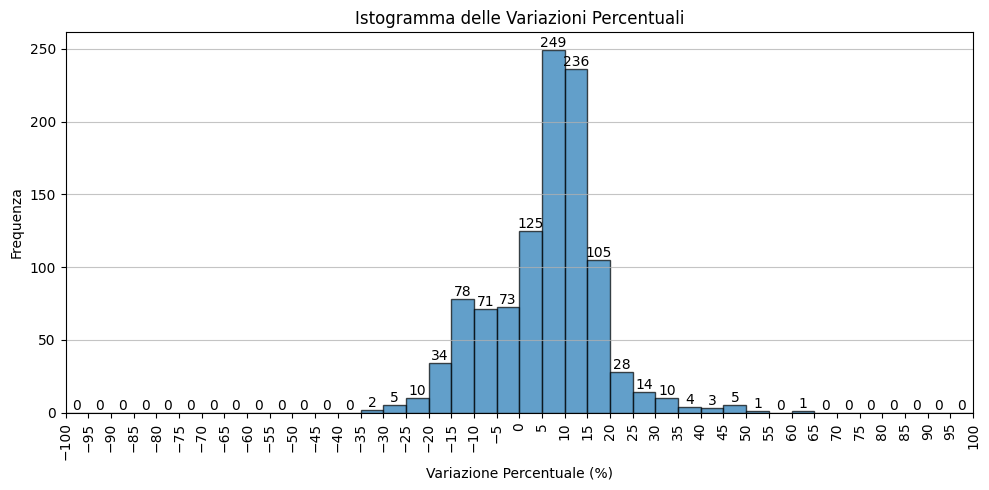

torch.Size([6, 30, 14])
torch.Size([6])


In [83]:
dataset = SequenceDataset(train_inputs, sequence_length=sequence_length, offset=offset,distance_pred=distance_pred)
dataset.show_sequence(plot_mode=True)
# Creazione dei DataLoader
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
for inputs in test_loader:
    print(inputs[0].shape)
    print(inputs[1].shape)
    break

In [84]:
model_dim = config['model_params']['dimension']
d_model = config['model_params']['d_model']
n_head = config['model_params']['n_head']
dim_feedforward = config['model_params']['dim_feedforward']
num_layers = config['model_params']['num_layers']
kernel_size = config['model_params']['kernel_size']
early_stopping_patience = config['model_params']['early_stopping_patience']
early_stopping_delta = config['model_params']['early_stopping_delta']


In [85]:
log_model_path = os.path.join(folders[2],f"log_modelli_{model_dim}Model_datasetSmall_{distance_pred}gg.csv")
if os.path.exists(log_model_path):
    # Read the first row of the CSV to extract the model name
    log_df = pd.read_csv(log_model_path)
    model_file = log_df.iloc[0]['Model_File']  # Assuming the column is named 'model_name'

    print(f"Model file extracted: {model_file}")

    d_model = log_df.iloc[0]['D_Model']
    n_head = log_df.iloc[0]['N_Head']
    dim_feedforward = log_df.iloc[0]['FF_Dim']
    num_layers = log_df.iloc[0]['Num_Layers']
    kernel_size = log_df.iloc[0]['Kernel_Size']
    # Construct the path to the model file
    model_file_path = os.path.join(folders[0], model_file)



Model file extracted: model_bdd0fc70-6802-42a1-b530-1b6168554795.pt


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Creazione del modello
model = TimeSeriesModel(train_inputs.shape[-1], output_size,"small",d_model = d_model, n_head= n_head, dim_feedforward= dim_feedforward, num_layers=num_layers, kernel_size=kernel_size)
model.load_state_dict(torch.load(model_file_path,map_location=device))

for m in model.modules():
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ReLU activation
    if isinstance(m, (nn.TransformerEncoderLayer)):
        nn.init.xavier_uniform_(m.linear1.weight)
        nn.init.xavier_uniform_(m.linear2.weight)
model.to(device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-86-25862ab638ce>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

TimeSeriesModel(
  (conv1): Conv1d(14, 16, kernel_size=(1,), stride=(1,), padding=same, padding_mode=reflect)
  (relu1): ReLU()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (relu2): ReLU()
  (classification_layer): Linear(in_features=16, out_features=3, bias=True)
)

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# # Definizione della loss e dell'optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(delta=early_stopping_delta, patience=early_stopping_patience)

In [88]:
# Valutazione del modello sul test set
test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
# #test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
print(f"Accuracy sul test set: {test_accuracy:.4f}")

all_predictions = 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

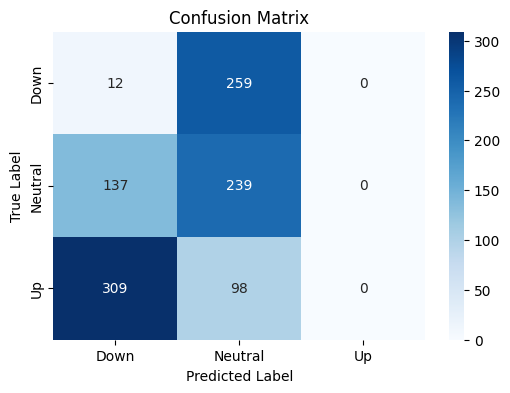

Matrice di Confusione:
[[ 12 259   0]
 [137 239   0]
 [309  98   0]]


In [89]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Calcolare la matrice di confusione
cm = confusion_matrix(all_targets, all_predictions)

# Visualizzare la matrice di confusione
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Neutral', 'Up'], yticklabels=['Down', 'Neutral', 'Up'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Stampa la matrice di confusione
print("Matrice di Confusione:")
print(cm)